In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

sns.set(style="whitegrid")
plt.style.use('fivethirtyeight')
%matplotlib inline

pd.set_option('display.max_columns', None)

np.random.seed(42)

In [ ]:
# Load the dataset
df = pd.read_csv('colorectal_cancer_dataset.csv')

# Check the shape of the dataset
print(f"Dataset Shape: {df.shape}")
print(f"Number of records: {df.shape[0]}")
print(f"Number of features: {df.shape[1]}")

# Display first few rows
df.head()

In [ ]:
# Check data types and missing values
df.info()

# Statistical summary of numerical columns
df.describe().T

# Check for missing values
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_data = pd.DataFrame({'Missing Values': missing_values, 
                             'Percentage': missing_percentage})
missing_data = missing_data[missing_data['Missing Values'] > 0]
missing_data.sort_values('Percentage', ascending=False)

In [ ]:
# Function to plot categorical distributions
def plot_categorical_counts(dataframe, columns, figsize=(18, 15)):
    plt.figure(figsize=figsize)
    
    # Calculate number of rows and columns for subplots
    n_cols = 3
    n_rows = (len(columns) + n_cols - 1) // n_cols
    
    for i, column in enumerate(columns, 1):
        plt.subplot(n_rows, n_cols, i)
        
        # Get value counts and sort by count
        value_counts = dataframe[column].value_counts().sort_values(ascending=False)
        
        # Create a bar plot
        sns.barplot(x=value_counts.index, y=value_counts.values)
        
        # Add labels and title
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Count')
        plt.xticks(rotation=45, ha='right')
        
        # Add count labels on top of bars
        for j, v in enumerate(value_counts.values):
            plt.text(j, v + 0.1, f'{v:,}', ha='center')
    
    plt.tight_layout()
    plt.show()

# Select categorical columns
categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
categorical_columns = [col for col in categorical_columns if col != 'Patient_ID']  # Exclude Patient_ID

# Plot the distribution of categorical variables
plot_categorical_counts(df, categorical_columns[:9])  # First set of categorical variables
plot_categorical_counts(df, categorical_columns[9:])  # Second set of categorical variables

In [ ]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)


In [ ]:
# Get descriptive statistics for numerical features
df.describe().T

# Create histograms for numerical variables
numerical_cols = ['Age', 'Tumor_Size_mm', 'Healthcare_Costs', 
                  'Incidence_Rate_per_100K', 'Mortality_Rate_per_100K']

plt.figure(figsize=(20, 15))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 2, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [ ]:
# Analyze target variable distribution
target_vars = ['Survival_5_years', 'Mortality', 'Survival_Prediction']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, var in enumerate(target_vars):
    counts = df[var].value_counts()
    axes[i].pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
    axes[i].set_title(f'Distribution of {var}')
plt.tight_layout()
plt.show()

# Look at Cancer Stage distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Cancer_Stage', data=df)
plt.title('Distribution of Cancer Stages')
plt.xticks(rotation=0)
plt.show()

# Treatment types across cancer stages
plt.figure(figsize=(12, 8))
treatment_stage = pd.crosstab(df['Treatment_Type'], df['Cancer_Stage'])
treatment_stage_pct = treatment_stage.div(treatment_stage.sum(axis=0), axis=1) * 100

treatment_stage_pct.plot(kind='bar', stacked=True)
plt.title('Treatment Types by Cancer Stage')
plt.xlabel('Treatment Type')
plt.ylabel('Percentage')
plt.legend(title='Cancer Stage')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Let's examine relationships between risk factors and survival
risk_factors = ['Family_History', 'Smoking_History', 'Alcohol_Consumption', 
                'Obesity_BMI', 'Diet_Risk', 'Physical_Activity', 'Diabetes',
                'Inflammatory_Bowel_Disease', 'Genetic_Mutation']

# Function to create a relationship plot
def plot_risk_survival_relationship(dataframe, risk_factors):
    plt.figure(figsize=(20, 15))
    
    for i, factor in enumerate(risk_factors, 1):
        plt.subplot(3, 3, i)
        
        # Create a crosstab of the risk factor and survival
        crosstab = pd.crosstab(dataframe[factor], dataframe['Survival_5_years'], 
                             normalize='index') * 100
        
        # Plot the percentage of survival for each category of the risk factor
        crosstab['Yes'].sort_values().plot(kind='barh', color='green')
        
        plt.title(f'5-Year Survival Rate by {factor}')
        plt.xlabel('Survival Rate (%)')
        plt.ylabel(factor)
        plt.xlim(0, 100)
        plt.grid(axis='x', linestyle='--', alpha=0.7)
        
    plt.tight_layout()
    plt.show()

# Plot the relationship between risk factors and survival
plot_risk_survival_relationship(df, risk_factors)

# Let's examine early detection and screening impact
detection_factors = ['Early_Detection', 'Screening_History']

plt.figure(figsize=(15, 6))
for i, factor in enumerate(detection_factors, 1):
    plt.subplot(1, 2, i)
    
    crosstab = pd.crosstab(df[factor], df['Survival_5_years'], 
                          normalize='index') * 100
    
    crosstab['Yes'].sort_values().plot(kind='barh', color='blue')
    
    plt.title(f'5-Year Survival Rate by {factor}')
    plt.xlabel('Survival Rate (%)')
    plt.ylabel(factor)
    plt.xlim(0, 100)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    
plt.tight_layout()
plt.show()

# Let's look at geographic patterns
plt.figure(figsize=(15, 8))
# Get top 10 countries by number of cases
top_countries = df['Country'].value_counts().nlargest(10).index.tolist()
country_survival = pd.DataFrame()

for country in top_countries:
    country_data = df[df['Country'] == country]
    survival_rate = (country_data['Survival_5_years'] == 'Yes').mean() * 100
    mortality_rate = (country_data['Mortality'] == 'Yes').mean() * 100
    
    country_survival = pd.concat([country_survival, pd.DataFrame({
        'Country': [country],
        'Survival_Rate': [survival_rate],
        'Mortality_Rate': [mortality_rate]
    })])

# Sort by survival rate
country_survival = country_survival.sort_values('Survival_Rate', ascending=False)

# Create a grouped bar chart
x = np.arange(len(country_survival))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 8))
ax.bar(x - width/2, country_survival['Survival_Rate'], width, label='5-Year Survival Rate')
ax.bar(x + width/2, country_survival['Mortality_Rate'], width, label='Mortality Rate')

ax.set_title('Survival and Mortality Rates by Country (Top 10 by Case Count)')
ax.set_xlabel('Country')
ax.set_ylabel('Rate (%)')
ax.set_xticks(x)
ax.set_xticklabels(country_survival['Country'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
# Cancer stage and survival rate correlation
plt.figure(figsize=(12, 6))
crosstab = pd.crosstab(df['Cancer_Stage'], df['Survival_5_years'], normalize='index') * 100
crosstab['Yes'].sort_values().plot(kind='barh', color='purple')
plt.title('5-Year Survival Rate by Cancer Stage')
plt.xlabel('Survival Rate (%)')
plt.ylabel('Cancer Stage')
plt.xlim(0, 100)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Let's examine the combination of early detection and cancer stage
plt.figure(figsize=(14, 7))
# Create pivot table
pivot = pd.pivot_table(df, 
                       values='Patient_ID', 
                       index=['Cancer_Stage'], 
                       columns=['Early_Detection', 'Survival_5_years'],
                       aggfunc='count')

# Convert to percentages by stage for better comparison
pivot_pct = pivot.div(pivot.sum(axis=1), axis=0) * 100

# Plot stacked bars
pivot_pct.plot(kind='bar', stacked=True, figsize=(14, 7))
plt.title('Impact of Early Detection on Survival by Cancer Stage')
plt.xlabel('Cancer Stage')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.legend(title='Early Detection & Survival', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Let's examine tumor size in relation to survival
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cancer_Stage', y='Tumor_Size_mm', hue='Survival_5_years', data=df)
plt.title('Tumor Size by Cancer Stage and Survival Status')
plt.ylabel('Tumor Size (mm)')
plt.xlabel('Cancer Stage')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Finally, let's create a correlation heatmap for numerical variables
numerical_cols = ['Age', 'Tumor_Size_mm', 'Healthcare_Costs', 
                  'Incidence_Rate_per_100K', 'Mortality_Rate_per_100K']

# Convert target variables to numeric for correlation analysis
df_corr = df.copy()
df_corr['Survival_5_years_num'] = (df_corr['Survival_5_years'] == 'Yes').astype(int)
df_corr['Mortality_num'] = (df_corr['Mortality'] == 'Yes').astype(int)
df_corr['Survival_Prediction_num'] = (df_corr['Survival_Prediction'] == 'Yes').astype(int)

# Add these to the numerical columns
numerical_cols.extend(['Survival_5_years_num', 'Mortality_num', 'Survival_Prediction_num'])

# Create correlation matrix
correlation_matrix = df_corr[numerical_cols].corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Variables')
plt.tight_layout()
plt.show()

In [ ]:
# Let's prepare categorical features
# First, identify categorical features
categorical_features = [col for col in df.columns if df[col].dtype == 'object' and 
                        col not in ['Patient_ID', 'Survival_5_years', 'Mortality', 'Survival_Prediction']]

# Create target variable
target = 'Survival_5_years'
y = (df[target] == 'Yes').astype(int)

# Display list of categorical features
print("Categorical features:")
print(categorical_features)
print("\nTarget distribution:")
print(y.value_counts(normalize=True) * 100)

# Let's prepare for modeling
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Split the data
X = df.drop(['Patient_ID', 'Survival_5_years', 'Mortality', 'Survival_Prediction'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print(f"\nNumber of numerical features: {len(numerical_cols)}")
print(f"Number of categorical features: {len(categorical_cols)}")

# Create preprocessing pipelines
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Check dataset sizes
print(f"\nTraining set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import xgboost as xgb
import time

# Define our modeling pipeline with different classifiers
def create_pipeline(classifier):
    return Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

# Create multiple modeling pipelines
models = {
    'Logistic Regression': create_pipeline(LogisticRegression(max_iter=1000, random_state=42)),
    'Random Forest': create_pipeline(RandomForestClassifier(n_estimators=100, random_state=42)),
    'XGBoost': create_pipeline(xgb.XGBClassifier(random_state=42))
}

# Function to evaluate models
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc
    }

# Train and evaluate each model
results = {}

for name, model in models.items():
    print(f"Training {name}...")
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    print(f"Evaluating {name}...")
    eval_results = evaluate_model(model, X_test, y_test)
    eval_results['training_time'] = training_time
    results[name] = eval_results
    
    print(f"{name} - Accuracy: {eval_results['accuracy']:.4f}, ROC AUC: {eval_results['roc_auc']:.4f}, Training time: {training_time:.2f}s")
    print("-" * 80)

# Convert results to a DataFrame for easy comparison
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('roc_auc', ascending=False)
print("\nModel Performance Summary:")
print(results_df)

# Get detailed classification report for the best model
best_model_name = results_df.index[0]
best_model = models[best_model_name]
y_pred = best_model.predict(X_test)
print(f"\nDetailed Classification Report for {best_model_name}:")
print(classification_report(y_test, y_pred))

# Plot ROC curves for all models
plt.figure(figsize=(10, 8))

for name, model in models.items():
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.4f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

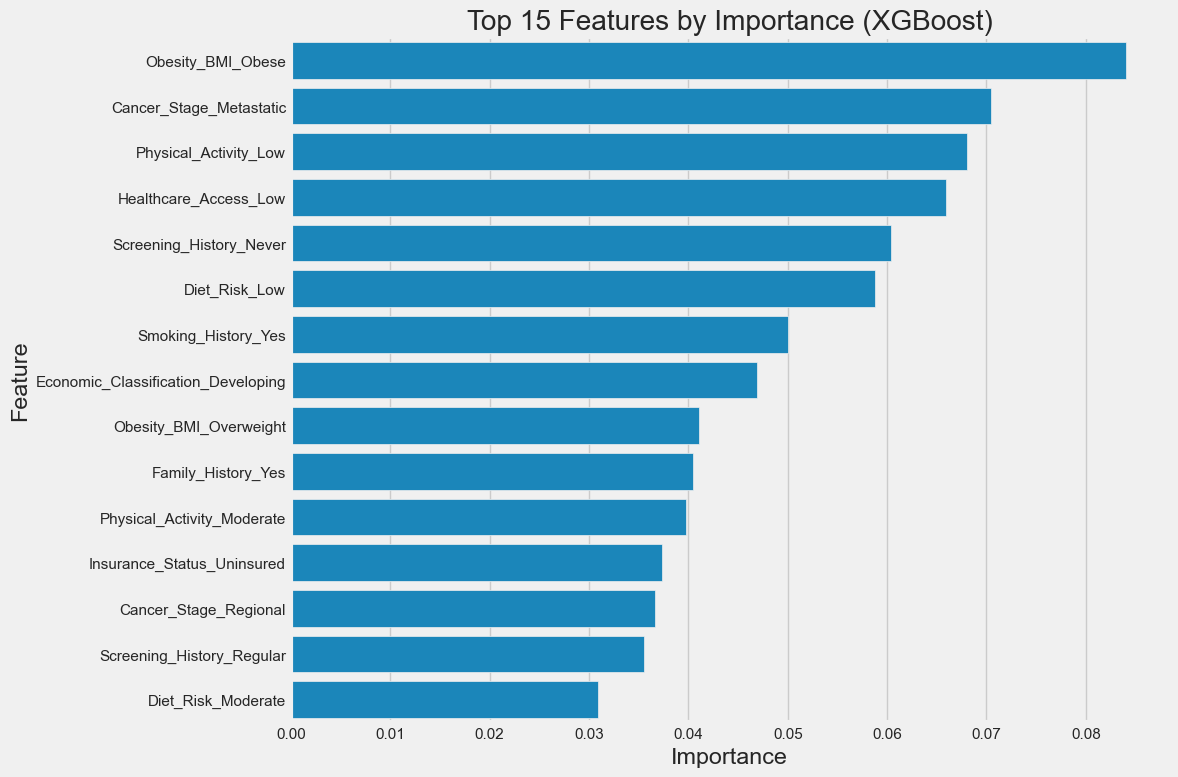

XGBoost - Accuracy: 0.5502, ROC AUC: 0.4960

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.24      0.30     13327
           1       0.60      0.75      0.67     20173

    accuracy                           0.55     33500
   macro avg       0.50      0.50      0.48     33500
weighted avg       0.52      0.55      0.52     33500



C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5441 - loss: 1.0044 - val_accuracy: 0.1077 - val_loss: 0.8566 - learning_rate: 0.0020
Epoch 2/50
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5967 - loss: 0.6867 - val_accuracy: 0.1077 - val_loss: 0.8779 - learning_rate: 0.0020
Epoch 3/50
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5974 - loss: 0.6761 - val_accuracy: 0.1077 - val_loss: 0.8686 - learning_rate: 0.0020
Epoch 4/50
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5986 - loss: 0.6746 - val_accuracy: 0.1077 - val_loss: 0.8571 - learning_rate: 0.0020
Epoch 5/50
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5966 - loss: 0.6752 - val_accuracy: 0.1077 - val_loss: 0.8720 - learning_rate: 0.0020
Epoch 6/50
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5998 - loss: 0.6735 - val_accuracy: 0.1077 - val_loss: 0.8725 - learning_rate: 4.0000e-04
Epoch 7/50
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5980 - loss: 0.673

C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

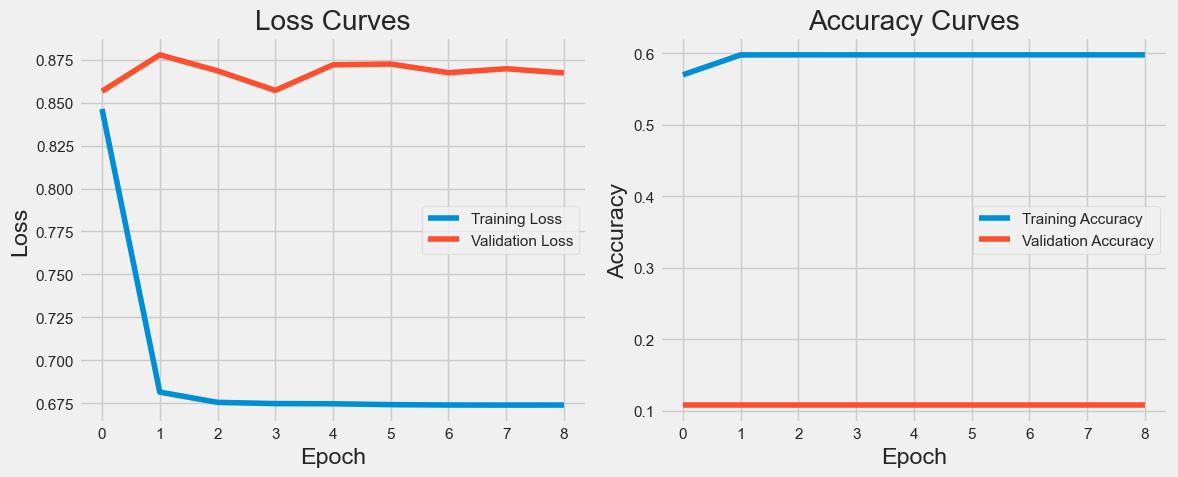

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# One-Hot Encode Categorical Variables
X_train_encoded = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# Handle Class Imbalance with SMOTE
smote = SMOTE(sampling_strategy="auto", random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_encoded, y_train)

# Standardize Numerical Features
scaler = StandardScaler()
X_resampled[numerical_cols] = scaler.fit_transform(X_resampled[numerical_cols])
X_test_encoded[numerical_cols] = scaler.transform(X_test_encoded[numerical_cols])

# Compute Class Weights
class_weights = compute_class_weight("balanced", classes=np.unique(y_resampled), y=y_resampled)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

### Train XGBoost Model
xgb_model = xgb.XGBClassifier(n_estimators=300, max_depth=5, learning_rate=0.005, random_state=42)
xgb_model.fit(X_resampled, y_resampled)

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X_resampled.columns,
    'Importance': xgb_model.feature_importances_
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
plt.title('Top 15 Features by Importance (XGBoost)')
plt.tight_layout()
plt.show()

# XGBoost Predictions
xgb_pred = xgb_model.predict(X_test_encoded)
xgb_accuracy = accuracy_score(y_test, xgb_pred)
xgb_roc_auc = roc_auc_score(y_test, xgb_model.predict_proba(X_test_encoded)[:, 1])
print(f"XGBoost - Accuracy: {xgb_accuracy:.4f}, ROC AUC: {xgb_roc_auc:.4f}")
print("\nXGBoost Classification Report:")
print(classification_report(y_test, xgb_pred))

### Improved Neural Network Model
def build_nn_model():
    model = Sequential([
        Dense(64, activation='relu', kernel_regularizer=l2(0.005), input_shape=(X_resampled.shape[1],)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu', kernel_regularizer=l2(0.005)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.002),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Train the Neural Network
nn_model = build_nn_model()

early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=1e-6)

history = nn_model.fit(
    X_resampled, y_resampled,
    epochs=50,
    batch_size=256,  # Increased batch size for stable learning
    validation_split=0.2,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

# Evaluate Neural Network
nn_pred_proba = nn_model.predict(X_test_encoded, verbose=0)
nn_pred = (nn_pred_proba > 0.5).astype(int)
nn_accuracy = accuracy_score(y_test, nn_pred)
nn_roc_auc = roc_auc_score(y_test, nn_pred_proba)
print(f"Neural Network - Accuracy: {nn_accuracy:.4f}, ROC AUC: {nn_roc_auc:.4f}")
print("\nNeural Network Classification Report:")
print(classification_report(y_test, nn_pred))

# Plot Learning Curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


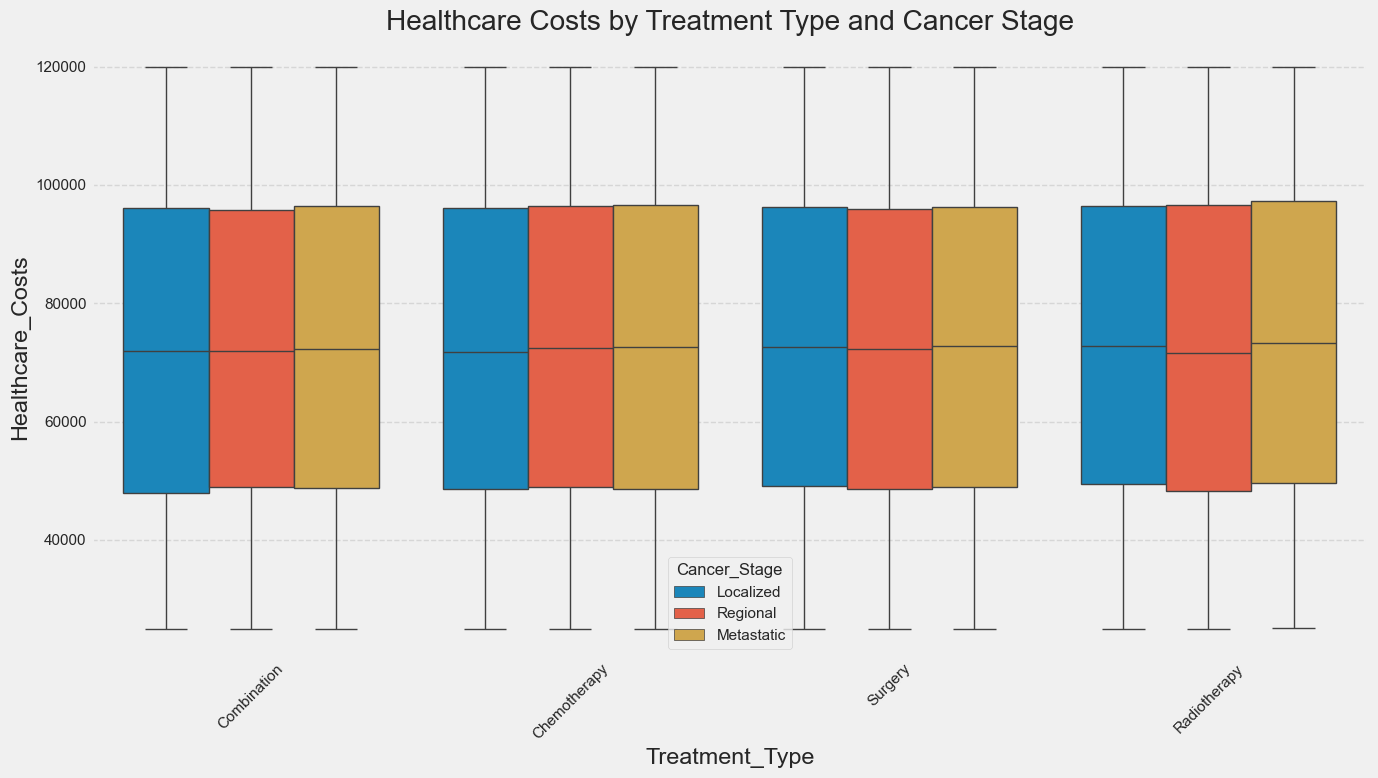

Healthcare Cost Prediction Results:
Mean Absolute Error: $23650.99
Root Mean Squared Error: $27334.75
R² Score: -0.0008


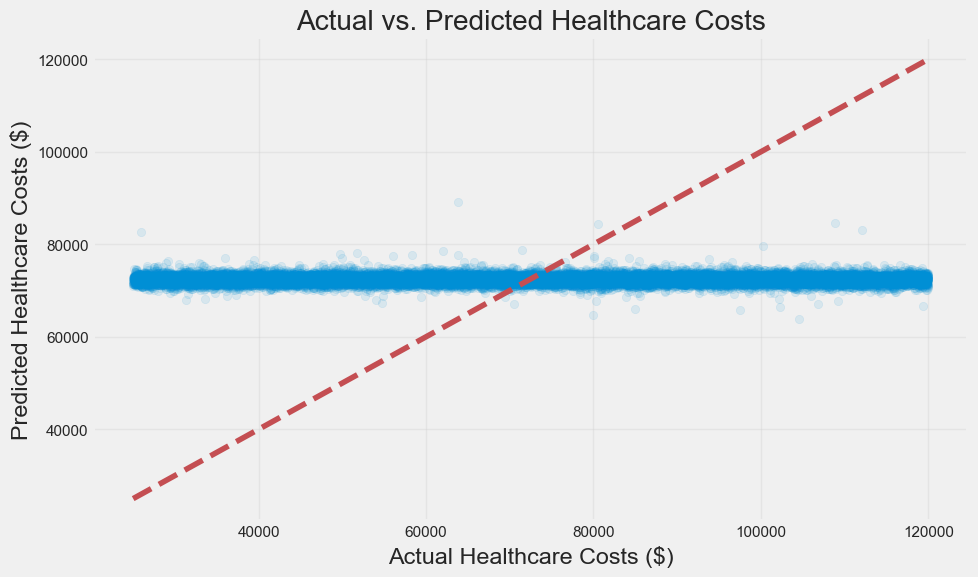

<Figure size 1400x1000 with 0 Axes>

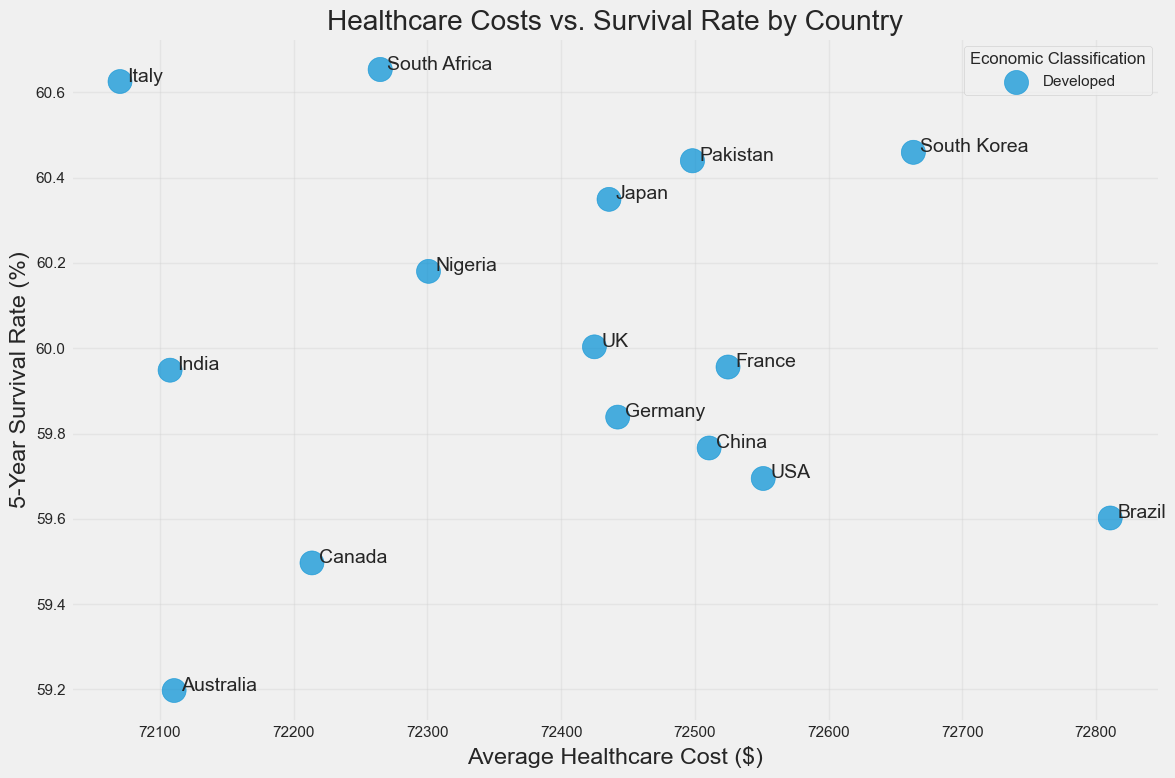

In [13]:
# Let's investigate healthcare costs prediction
# First, let's look at the distribution of healthcare costs by treatment type and cancer stage
plt.figure(figsize=(14, 8))
sns.boxplot(x='Treatment_Type', y='Healthcare_Costs', hue='Cancer_Stage', data=df)
plt.title('Healthcare Costs by Treatment Type and Cancer Stage')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Create a regression model to predict healthcare costs
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Target for regression
y_cost = X_train['Healthcare_Costs']
X_train_reg = X_train.drop('Healthcare_Costs', axis=1)

y_cost_test = X_test['Healthcare_Costs']
X_test_reg = X_test.drop('Healthcare_Costs', axis=1)

# Create the regression pipeline
reg_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, [col for col in numerical_cols if col != 'Healthcare_Costs']),
        ('cat', categorical_transformer, categorical_cols)
    ])

reg_pipeline = Pipeline(steps=[
    ('preprocessor', reg_preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

# Train and evaluate
reg_pipeline.fit(X_train_reg, y_cost)
cost_pred = reg_pipeline.predict(X_test_reg)

# Evaluate the regression model
mse = mean_squared_error(y_cost_test, cost_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_cost_test, cost_pred)
r2 = r2_score(y_cost_test, cost_pred)

print(f"Healthcare Cost Prediction Results:")
print(f"Mean Absolute Error: ${mae:.2f}")
print(f"Root Mean Squared Error: ${rmse:.2f}")
print(f"R² Score: {r2:.4f}")

# Plot actual vs predicted costs
plt.figure(figsize=(10, 6))
plt.scatter(y_cost_test, cost_pred, alpha=0.1)
plt.plot([y_cost_test.min(), y_cost_test.max()], [y_cost_test.min(), y_cost_test.max()], 'r--')
plt.xlabel('Actual Healthcare Costs ($)')
plt.ylabel('Predicted Healthcare Costs ($)')
plt.title('Actual vs. Predicted Healthcare Costs')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Create a regional analysis dashboard
# Analyze survival rates by country and economic status
plt.figure(figsize=(14, 10))

# Get top 15 countries by count
top_countries = df['Country'].value_counts().nlargest(15).index

# Prepare data for plotting
country_data = []
for country in top_countries:
    country_subset = df[df['Country'] == country]
    survival_rate = (country_subset['Survival_5_years'] == 'Yes').mean() * 100
    early_detection_rate = (country_subset['Early_Detection'] == 'Yes').mean() * 100
    avg_healthcare_cost = country_subset['Healthcare_Costs'].mean()
    economic_class = country_subset['Economic_Classification'].mode()[0]
    
    country_data.append({
        'Country': country,
        'Survival_Rate': survival_rate,
        'Early_Detection_Rate': early_detection_rate,
        'Avg_Healthcare_Cost': avg_healthcare_cost,
        'Economic_Classification': economic_class
    })

country_df = pd.DataFrame(country_data)

# Sort by survival rate
country_df = country_df.sort_values('Survival_Rate', ascending=False)

# Plot survival rate vs. healthcare costs colored by economic classification
plt.figure(figsize=(12, 8))
for ec in country_df['Economic_Classification'].unique():
    subset = country_df[country_df['Economic_Classification'] == ec]
    plt.scatter(subset['Avg_Healthcare_Cost'], subset['Survival_Rate'], 
                s=subset['Early_Detection_Rate']*5, label=ec, alpha=0.7)

plt.xlabel('Average Healthcare Cost ($)')
plt.ylabel('5-Year Survival Rate (%)')
plt.title('Healthcare Costs vs. Survival Rate by Country')
plt.legend(title='Economic Classification')
plt.grid(alpha=0.3)

# Add country labels
for i, row in country_df.iterrows():
    plt.annotate(row['Country'], 
                 (row['Avg_Healthcare_Cost'], row['Survival_Rate']),
                 xytext=(5, 0), textcoords='offset points')

plt.tight_layout()
plt.show()